# Финальный проект специализации "Машинное обучение и анализ данных"
## Идентификация интернет-пользователей
*Алексей Галак*

### Цели и задачи проекта

В рамках проекта решается задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Мы будем решать похожую задачу. Есть некоторый определенный, выделенный пользователь (назовем его Alice). По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком (сессии), мы будем определять, Alice это или кто-то другой (взломщик).

Для этой задачи есть [соревнование](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle, на которое мы и будем опираться при итоговой оценке качества модели и для сравнения результатов с другими участниками соревнования.

Мы будем строить вероятностную модель бинарной классификации, которая для каждой сессии будет вычислять вероятность того, что эта сессия принадлежит Alice. Соответственно, чем ближе эта вероятность к 1, тем больше уверенность модели в том, что эта сессия принадлежит Alice, а чем она ближе к 0, тем больше уверенность в том, что сессия принадлежит не Alice.

### Описание данных

Обучающая выборка приведена в файле `train_sessions.csv`,  тестовая (без целевого признака) - в файле `test_sessions.csv`.

Данные представлены в виде сессий - последовательностей сайтов, посещенных одним человеком. Каждый посещенный сайт представлен идентификатором и временем посещения. Длина сессии ограничена 10 сайтами, но может быть и меньше (в этом случае соответствующие сайту признаки отсутствуют). Сопоставление сайтов (доменных имен) и их идентификаторов приведено в pickle-файле со словарем `site_dic.pkl`.
* Признаки `site_i`, i=1..10 – идентификаторы посещенных сайтов
* Признаки `time_i`, i=1..10 – время посещения сайтов `site_i`
* Целевой признак `target` – индикатор того, что сессия принадлежит Alice (1 - Alice, 0 - кто-то другой)

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import re
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix, hstack as shstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import eli5
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.7.9
IPython 7.19.0

numpy 1.19.2
scipy 1.5.2
pandas 1.1.3
matplotlib 3.3.2
sklearn 0.23.2

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 28770c446d6ae226534e116eccd260ef9cc873b4


In [3]:
def csr_hstack(arglist):
    return csr_matrix(shstack(arglist))

In [4]:
PATH_TO_DATA = '../data/raw'
PATH_TO_SUBMISSIONS = '../kaggle_submissions'
SEED = 17

Считаем данные, кодируя отсутствующие сайты нулем:

In [5]:
site_columns = ['site%d' % i for i in range(1, 10+1)]
time_columns = ['time%d' % i for i in range(1, 10+1)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=time_columns)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=time_columns)

train_df[site_columns] = train_df[site_columns].fillna(0).astype('int')
test_df[site_columns] = test_df[site_columns].fillna(0).astype('int')

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175,2014-02-28 10:55:59,177,2014-02-28 10:55:59,177,2014-02-28 10:57:06,178,2014-02-28 10:57:11,0


In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35,2014-10-04 11:19:53,22,2014-10-04 11:19:54,321,2014-10-04 11:19:54,23,2014-10-04 11:19:54,2211,2014-10-04 11:19:54,6730,2014-10-04 11:19:54,21,2014-10-04 11:19:54,44582,2014-10-04 11:20:00,15336,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782,2014-07-03 11:00:53,782,2014-07-03 11:00:58,782,2014-07-03 11:01:06,782,2014-07-03 11:01:09,782,2014-07-03 11:01:10,782,2014-07-03 11:01:23,782,2014-07-03 11:01:29,782,2014-07-03 11:01:30,782,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55,2014-12-05 15:55:13,55,2014-12-05 15:55:14,55,2014-12-05 15:56:15,55,2014-12-05 15:56:16,55,2014-12-05 15:56:17,55,2014-12-05 15:56:18,55,2014-12-05 15:56:19,1445,2014-12-05 15:56:33,1445,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022,2014-11-04 10:03:19,50,2014-11-04 10:03:20,222,2014-11-04 10:03:21,202,2014-11-04 10:03:21,3374,2014-11-04 10:03:22,50,2014-11-04 10:03:22,48,2014-11-04 10:03:22,48,2014-11-04 10:03:23,3374,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301,2014-05-16 15:05:32,301,2014-05-16 15:05:33,66,2014-05-16 15:05:39,67,2014-05-16 15:05:40,69,2014-05-16 15:05:40,70,2014-05-16 15:05:40,68,2014-05-16 15:05:40,71,2014-05-16 15:05:40,167,2014-05-16 15:05:44


#### Исправление данных

Часть данных в этом соревновании была составлена некорректно: дни и месяцы переставлены местами там, где это было возможно (день <= 12). Убедимся в этом:

In [8]:
from matplotlib.colors import ListedColormap

def show_Ymd_distribution(times):
    data_Ymd = times.dt.strftime('%Y-%m-%d').value_counts().sort_index().index
    time_occurences = np.zeros((2, 12, 31))
    year2ind = {2013: 0, 2014: 1}
    for Ymd in data_Ymd:
        Y, m, d = map(int, Ymd.split('-'))
        i1 = year2ind[Y]
        i2, i3 = m-1, d-1
        time_occurences[i1, i2, i3] = 1
    
    for year in year2ind:
        plt.figure(figsize=(12, 4))
        sns.heatmap(time_occurences[year2ind[year]], 
                    xticklabels=range(1, 31+1), yticklabels=range(1, 12+1), 
                    linewidths=0.1, center=0.5, cmap=ListedColormap(['lightgrey', 'green'])
        )
        plt.title(str(year))
        plt.xlabel('Day')
        plt.ylabel('Month')
        plt.show()

Распределение на обучающей выборке:

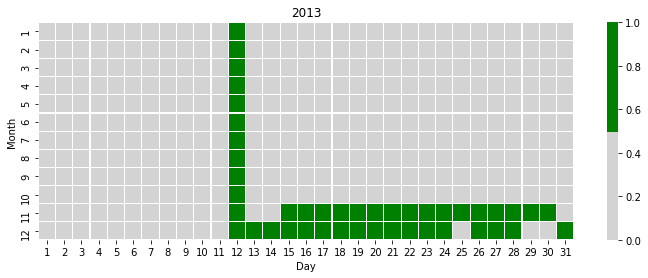

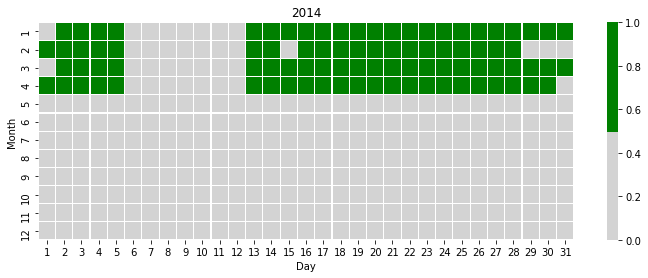

In [9]:
show_Ymd_distribution(train_df['time1'])

Видно, что в 2013 году данные в начале 12го месяца отсутствуют, но зато присутствуют данные 12го числа каждого месяца. В 2014 году отсутствует кусок данных, где день лежит в диапазаоне от 6 до 12. Этот кусок попал в тестовые данные в "транспонированном" виде:

Распределение на тестовой выборке:

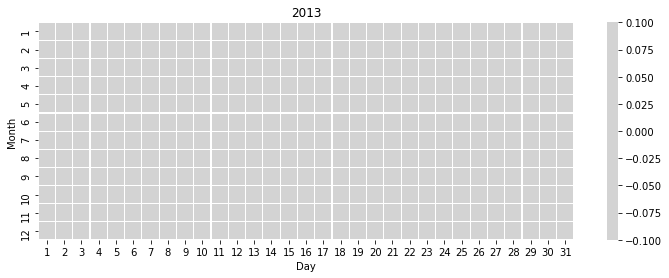

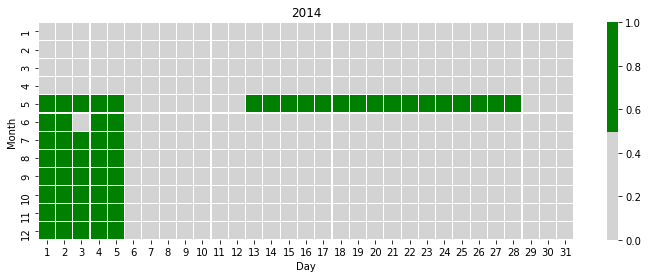

In [10]:
show_Ymd_distribution(test_df['time1'])

Исправим данные, переставив месяцы и дни местами там, где это необходимо:

In [11]:
def fix_incorrect_date_formats(df, columns_to_fix):
    for time_col in columns_to_fix:
        d = df[time_col]
        index_mask = (d.dt.day <= 12)
        d_fix = d[index_mask]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[index_mask, time_col] = d_fix
    return df

In [12]:
train_df = fix_incorrect_date_formats(train_df, time_columns)
test_df = fix_incorrect_date_formats(test_df, time_columns)

Распределение на обучающей выборке:

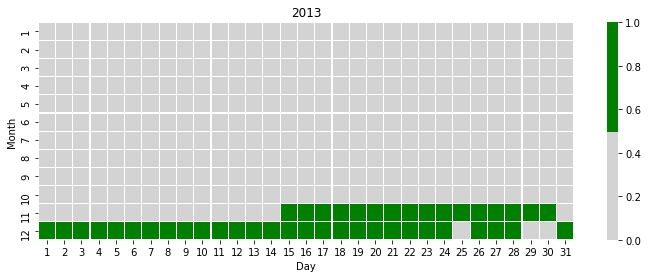

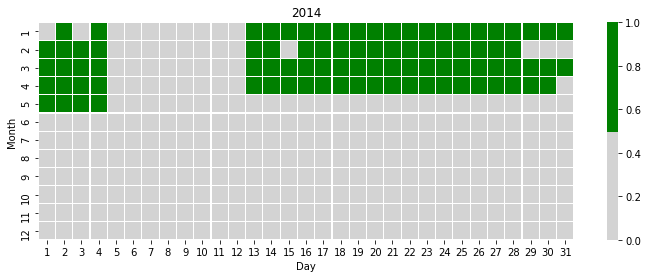

In [13]:
show_Ymd_distribution(train_df['time1'])

Распределение на тестовой выборке:

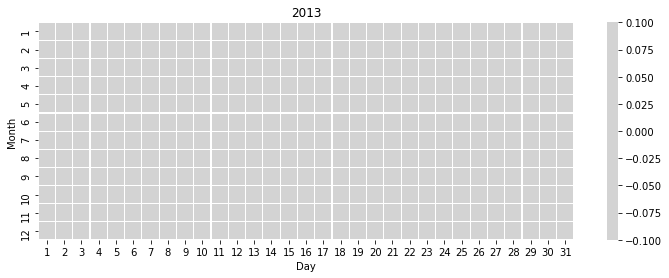

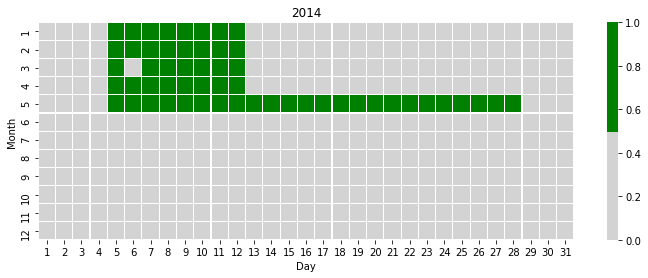

In [14]:
show_Ymd_distribution(test_df['time1'])

Видно, что теперь данные в совокупности покрывают весь период с 15.11.2013 по 28.05.2014. Тестовые данные все еще выделены странно, но тут уже ничего не поделать - так они были выбраны авторами соревнования. По всей видимости, планировалось взять более поздние данные в качестве тестовых (с мая 2014), но из-за ошибки получилось вот так.

---

Отсортируем обучающую выборку, чтобы в дальнейшем правильно разделять выборку на фолды в кросс-валидации. Тестовую выборку сортировать не будем, т.к. ее порядок нужно сохранить для сабмишна на kaggle:

In [15]:
train_df = train_df.sort_values(by='time1')

Загрузим словарь с сопоставлениями сайт - идентификатор:

In [16]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as fin:
    site_dic = pickle.load(fin)
list(site_dic.items())[:5]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104)]

### Методика измерения качества

Модель оценивается на основании предлагаемой в соревновании метрики ROC-AUC - площади под ROC-кривой. Чем выше показатель ROC-AUC, тем качественнее классификатор, при этом значение 0.5 демонстрирует непригодность выбранного метода классификации (соответствует случайному угадыванию либо константному предсказанию).

### Предобработка данных и создание признаков

На основе исходных данных создадим признаки - количества вхождений сайта в сессию, по одному для каждого сайта. Получается большая разреженная матрица.

Кроме того, создадим новые признаки:
* `time_of_day` - время суток. 0 - ночь (0:00-5:00), 1 - утро (6:00-11:00), 2 - день (12:00-17:00), 3 - вечер (18:00-23:00)
* `session_timespan` - длительность сессии в секундах
* `day_of_week` - день недели, от 0 (понедельник) до 6 (воскресенье)
* `year_month` - год и месяц в виде конкатенации (например, 09.2013 кодируется числом 1309)

Кодировать признаки будем с помощью:
* `time_of_day` : `OneHotEncoder`
* `session_timespan` : `StandardScaler`
* `day_of_week`, `year_month` : `MaxAbsScaler`

In [17]:
def sparsify_data(X, vectorizer_params, train_part=None, method='count'):
    id2site = {v:k for (k, v) in site_dic.items()}
    id2site[0] = 'unknown'
    
    X_text = [' '.join(map(id2site.get, row)) if len(row) > 0 else '' for row in X]

    if method == 'count':
        vectorizer = CountVectorizer(**vectorizer_params)
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer(**vectorizer_params)
    else:
        raise ValueError(method)
    
    if train_part is None:
        vectorizer.fit(X_text)
    else:
        vectorizer.fit(X_text[:train_part])
    
    return vectorizer.transform(X_text)
        

def make_site_names(X_sites, site_dic, sparse=True, method='count', ngram_range=(1, 1)):
    IP_regex = r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'
    site_ids_to_names = {}
    for site, site_id in site_dic.items():
        site_ids_to_names[site_id] = site if re.match(IP_regex, site) else site.split('.')[-2]
    site_ids_to_names[0] = '.' if sparse else '' #fill value for missing sites
    X_site_names = np.array([[site_ids_to_names[el] for el in row] for row in X_sites.values])
    if sparse:
        vectorizer_params = {'ngram_range': ngram_range, 'token_pattern': r'[^ ]+', 'stop_words': ['.']}
        return sparsify_data(X_site_names, vectorizer_params=vectorizer_params, method=method)
    else:
        return X_site_names

def prepare_features(X_features, feature_types):
    def extract_features(feat_type):
        empty_array = np.array([]).reshape(X_features.shape[0], 0)
        if len(feature_types[feat_type]) > 0:
            return X_features[feature_types[feat_type]].values
        else:
            return empty_array
    
    def transform_features(transformer, feat_array):
        if feat_array.shape[1] > 0:
            return transformer.fit_transform(feat_array)
        else:
            return feat_array
    
    prepared_features = extract_features('prepared')
    encoded_features = transform_features(OneHotEncoder(sparse=True, dtype=np.int16), extract_features('categorical'))
    log_features = np.log(extract_features('to_log') + 1)
    #also standard scale log features
    scaled_standard_features = transform_features(StandardScaler(), np.hstack([extract_features('to_scale_standard'), 
                                                                               log_features]))
    scaled_maxabs_features = transform_features(MaxAbsScaler(), extract_features('to_scale_maxabs'))
    
    return csr_hstack([prepared_features, 
                       encoded_features, 
                       scaled_standard_features, 
                       scaled_maxabs_features])

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def count_popular_sites(sites_df, popular_sites_indicators):
    result = []
    for sites_row, popular_sites_mask in zip(sites_df.values, popular_sites_indicators):
        popular_sites = sites_row[popular_sites_mask]
        result.append( len(popular_sites) )
    return result

def get_session_timespan(row):
    row_ne = row[~np.isnat(row)]
    return int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))

def between(left, x, right):
    return left <= x and x <= right

def get_time_of_day(hour):
    if between(0, hour, 6):
        return 0
    elif between(7, hour, 11):
        return 1
    elif between(12, hour, 18):
        return 2
    elif between(19, hour, 23):
        return 3

def make_features(X_sites, X_times, prepare=True):
    X_features = pd.DataFrame(index=X_sites.index)
    
    sites_counter = Counter()
    for row in X_sites.values:
        sites_counter.update(row)
    popular_sites = [site for site, count in sites_counter.most_common(30)]
    popular_sites_indicators = np.isin(X_sites.values, popular_sites)
    
    X_features['start_hour'] = X_times['time1'].dt.hour
    X_features['time_of_day'] = X_features['start_hour'].apply(get_time_of_day)
    X_features['day_of_week'] = X_times['time1'].dt.dayofweek
    X_features['weekend'] = (np.isin(X_features['day_of_week'].values, [5, 6])).astype(int)
    #X_features['#unique_sites'] = X_sites.apply(count_unique_sites, raw=True, axis=1)
    X_features['#popular_sites'] = count_popular_sites(X_sites, popular_sites_indicators)
    #X_features['%popular_sites'] = X_features['#popular_sites'] / X_features['#unique_sites']
    X_features['year_month'] = X_times['time1'].dt.strftime('%y%m').astype(int)
    X_features['session_timespan'] = X_times.apply(lambda row: get_session_timespan(row), axis=1, raw=True)
    
    feature_types = {'prepared': [],
                     'categorical': ['time_of_day'], 
                     'to_log': [], 
                     'to_scale_standard': ['session_timespan'], 
                     'to_scale_maxabs': ['day_of_week', 'year_month']
                    }
    
    if prepare:
        return prepare_features(X_features, feature_types)
    else:
        return X_features

Разделим сайты и время их посещения в отдельные датафреймы:

In [18]:
train_test_df = pd.concat([train_df, test_df], sort=False)
train_test_df_sites = train_test_df[site_columns]
train_test_df_times = train_test_df[time_columns]

Построим признаки и составим обучающую и тестовую выборки:

In [19]:
%%time
train_part=len(train_df)
vectorizer_params = {'ngram_range': (1, 5), 'max_features': 50000, 'tokenizer': lambda s: s.split(), 'stop_words': ['unknown']}
train_test_sparse_with_features = csr_hstack([sparsify_data(train_test_df_sites.values, vectorizer_params, train_part, method='tfidf'), 
                                              make_features(train_test_df_sites, train_test_df_times) 
                                             ])

X_train = train_test_sparse_with_features[:train_part]
X_test = train_test_sparse_with_features[train_part:]
y = train_df['target'].astype('int').values

Wall time: 39.1 s


### Первичный анализ признаков

Чтобы проанализировать признаки, нам они понадобятся в незакодированном виде:

In [20]:
train_features = make_features(train_test_df_sites, train_test_df_times, prepare=False)[:len(train_df)]

In [21]:
def plot_feature_hist(feature, data, y, bins=None, apply_func=lambda x: x, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    titles = ['Alice', 'Not Alice']
    targets = [1, 0]
    colors = ['green', 'lightblue']
    
    for i in range(2):
        ax = axes[i]
        data[y == targets[i]][feature].apply(apply_func).hist(bins=bins, ax=ax, color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel(feature)
        ax.set_ylabel(u'Количество сессий')

def plot_feature_count(feature, data, y, ticks=None, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    titles = ['Alice', 'Not Alice']
    targets = [1, 0]
    
    for i in range(2):
        ax = axes[i]
        if ticks:
            sns.countplot(feature, data=data[y == targets[i]], order=ticks.keys(), ax=ax)
            ax.set_xticklabels(ticks.values())
        else:
            sns.countplot(feature, data=data[y == targets[i]], ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel(feature)
        ax.set_ylabel(u'Количество сессий')

Распределение часа начала сессии:

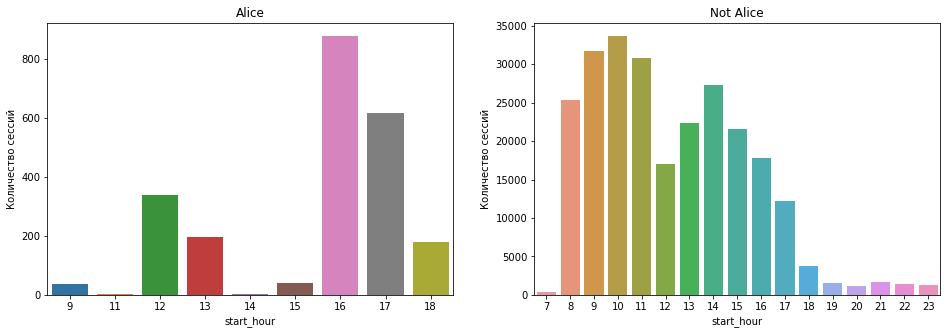

In [22]:
plot_feature_count('start_hour', train_features, y)

*Распределения существенно отличаются. Активность Alice сконцентрирована в трех временных промежутках: 9 часов, 12-13 часов и 15-18 часов, при этом активность растет в течение дня. Активность не Alice понижается в течение дня, начинается раньше (в 8 часов) и заканчивается позже (в 23 часа), имеет лишь один спад в районе 12 часов и сильно понижается после 17 часов.*

Распределение времени суток:

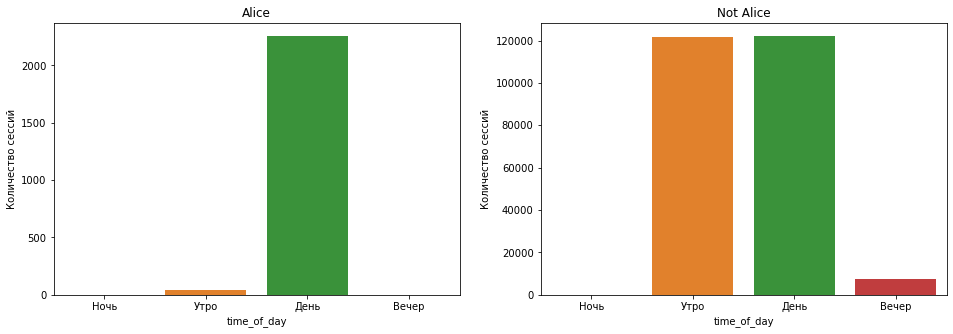

In [23]:
ticks = {0: u'Ночь', 1: u'Утро', 2: u'День', 3: u'Вечер'}
plot_feature_count('time_of_day', train_features, y, ticks=ticks)

*Как и было отмечено ранее, Alice активна в основном днем (12:00-17:00), в то время, как не Alice имеет активность утром, сопоставимую с активностью днем.*

Распределение дня недели:

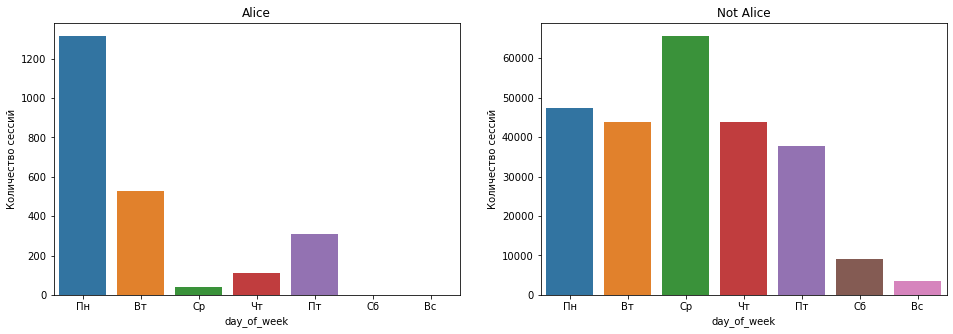

In [24]:
ticks = {0: u'Пн', 1: u'Вт', 2: u'Ср', 3: u'Чт', 4: u'Пт', 5: u'Сб', 6: u'Вс'}
plot_feature_count('day_of_week', train_features, y, ticks=ticks)

*Активность Alice максимальна в понедельник, и при этом очень мала в среду и в выходные. Активность не Alice относительно равномерна в будни и на выходные имеет лишь некоторый спад.*

Распределение года+месяца:

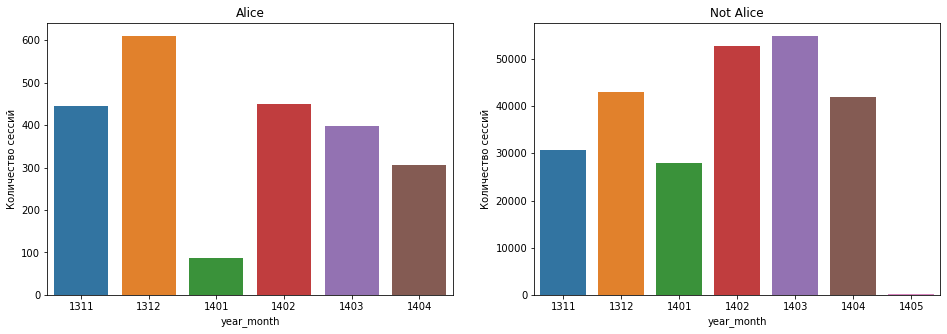

In [26]:
plot_feature_count('year_month', train_features, y)

*C мая по август, а также в октябре 2013 года Alice была неактивна. В остальные месяцы тоже есть отличия в распределениях Alice и не Alice.*

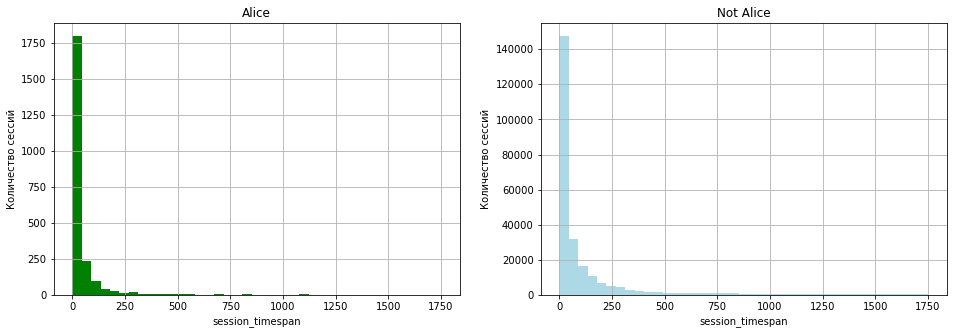

In [27]:
plot_feature_hist('session_timespan', train_features, y, bins=np.linspace(0, 1750, 40))

*Сессии всех пользователей в основном очень быстрые, но для Alice длинные сессии менее характерны, чем для не Alice.*

### Обучение модели

Зададим тип кросс-валидации. Так как наши данные параметризованы по времени, лучше было бы использовать `TimeSeriesSplit`, но итоговое качество модели оказалось хуже и на валидации, и на публичном лидерборде. Наверное, проблема в том, что тестовые данные из-за ошибки были взяты не с конца выборки, и обучающая выборка теперь не представляет собой временной ряд.

In [28]:
#tss = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Вспомогательная функция для отрисовки кривых валидации:

In [29]:
def plot_validation_curves(params, grid_cv_results_, scale='linear', figsize=(15, 10)):
    param_name, param_values = list(params.items())[0]
    plt.figure(figsize=figsize)
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    print('CV std: {}'.format(max(zip(valid_mu, valid_std), key=lambda x: x[0])[1]))
    if scale == 'linear':
        train_line = plt.plot(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.plot(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    if scale == 'log':
        train_line = plt.semilogx(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.semilogx(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.legend()

#### SGDClassifier

Обучать будем модель логистической регресии. В предыдущих заданиях было выяснено, что из простых моделей логистическая регрессия показывает наилучшее качество. Так как данных довольно много, будем использовать стохастический градиентный спуск (`SDGClassifier`).

Параметр `alpha` будем подбирать с помощью `GridSearchCV`. Сначала будем перебирать его на промежутке от 1e-6 до 1e3:

Best alpha = 1e-06
Best CV score (roc auc) = 0.9774571168434563
CV std: 0.0047115102469577445
Wall time: 34.2 s


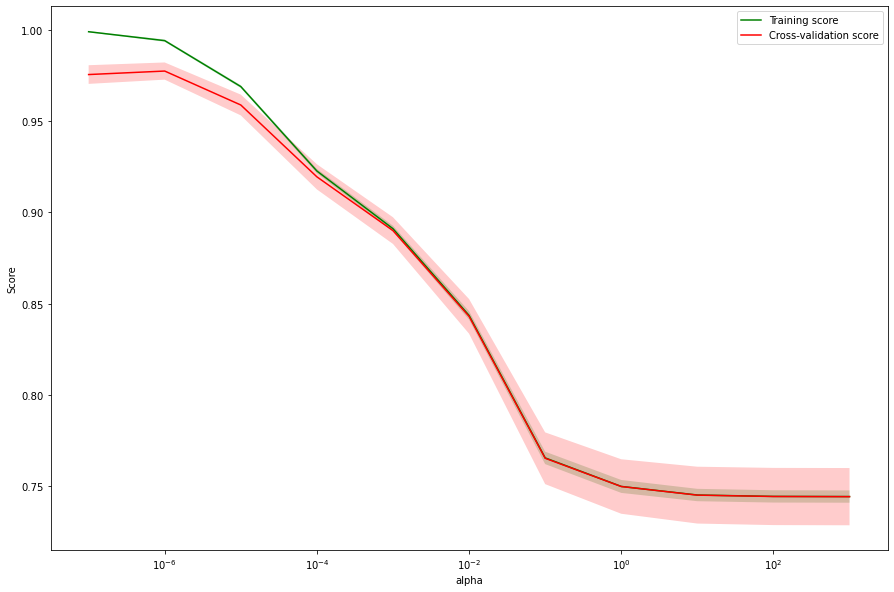

In [30]:
%%time
sgd_logit_params = {'alpha': np.logspace(-7, 3, 11)}

sgd_logit = SGDClassifier(loss='log', random_state=SEED)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf, return_train_score=True)
sgd_logit_grid_searcher.fit(X_train, y)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params, sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

Теперь, когда видно, где параметр `alpha` достигает максимума, переберем его вновь в более подходящем промежутке:

Best alpha = 4.641588833612782e-07
Best CV score (roc auc) = 0.9788227273690755
CV std: 0.0036066112966136976
Wall time: 2min 6s


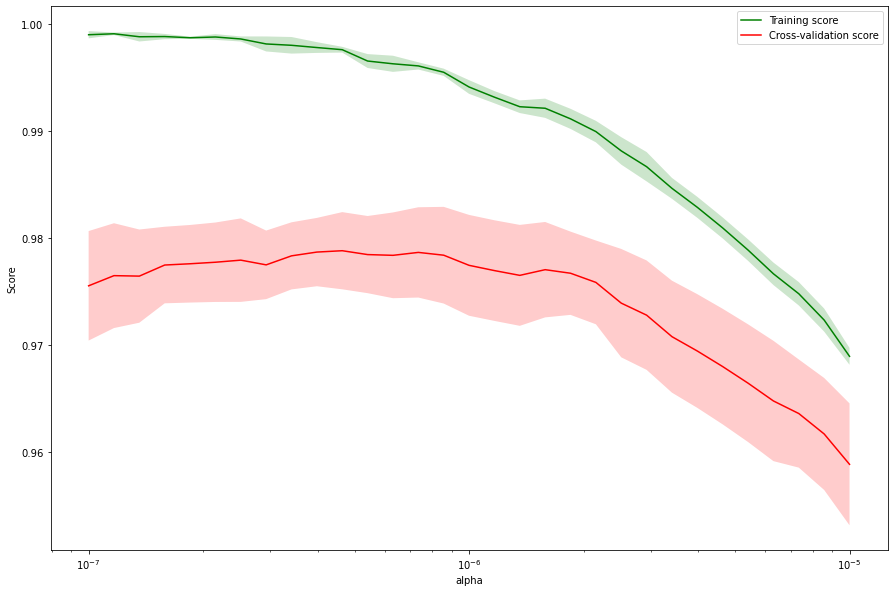

In [31]:
%%time
sgd_logit_params = {'alpha': np.logspace(-7, -5, 31)}

sgd_logit = SGDClassifier(loss='log', random_state=SEED)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf, return_train_score=True)
sgd_logit_grid_searcher.fit(X_train, y)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params, sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

Улучшилось и качество на кросс-валидации, и стандартное отклонение. Новое `alpha` однозначно лучше, хотя и ненамного.

Построим кривые обучения:

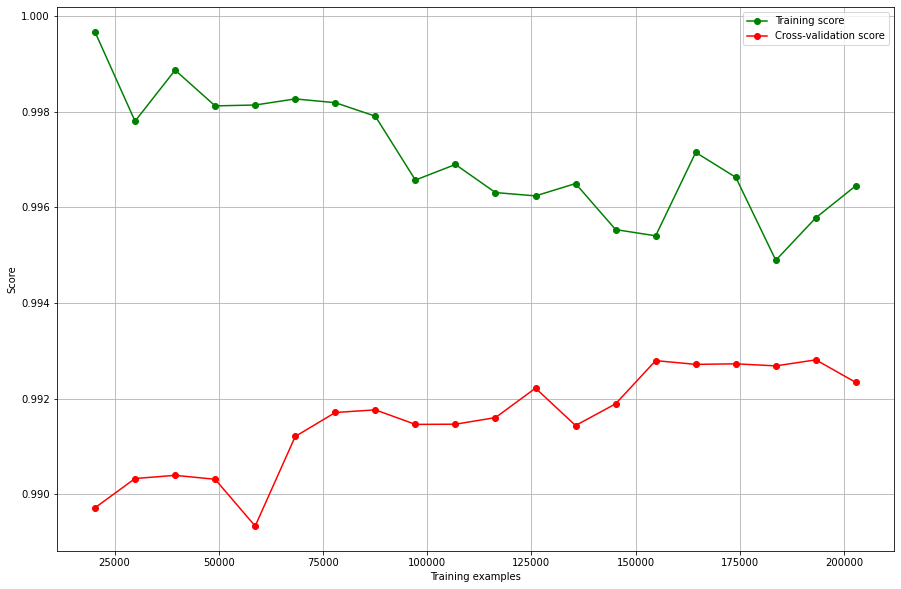

Wall time: 50.5 s


In [32]:
%%time
train_sizes_abs, train_scores, val_scores = learning_curve(sgd_logit_grid_searcher.best_estimator_, X_train, y, 
                                                            train_sizes=np.linspace(0.1, 1.0, 20), cv=skf)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
plt.figure(figsize=(15, 10))
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

Графики изрезанные, новые данные довольно сильно влияют на качество. Это неудивительно, учитывая то, что мы используем стохастический градиентный спуск, а также из-за того, как странно устроено распределение наших данных во времени. В среднем качество на обучении и кросс-валидации, похоже, вышли на плато и остается некоторый разрыв. Имеется небольшое недообучение.

#### LogisticRegression

Теперь попробуем логистическую регрессию с обычным градиентным спуском, а не стохастическим. Эта модель будет обучаться дольше, но возможно даст лучшее качество:

C: 10.0, score: 0.9797115095998112
Wall time: 43.9 s


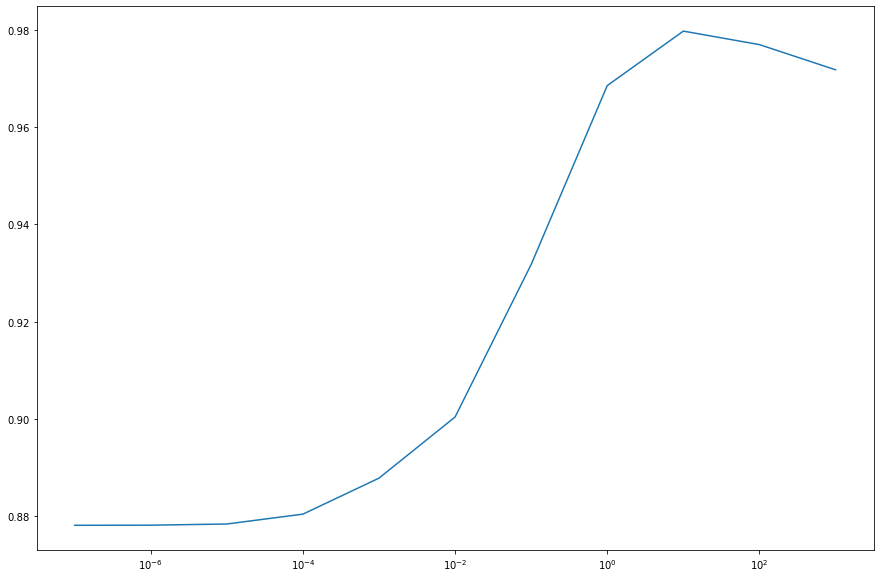

In [33]:
%%time
logit_params = np.logspace(-7, 3, 11)

logit = LogisticRegressionCV(Cs=logit_params, cv=skf, multi_class='ovr', scoring='roc_auc', random_state=SEED, n_jobs=-1)
logit.fit(X_train, y)
logit_cv_scores = logit.scores_[1]
logit_mean_cv_scores = np.apply_along_axis(np.mean, 0, logit_cv_scores)
logit_best_C, logit_best_score = max(zip(logit_params, logit_mean_cv_scores), key=lambda x: x[1])
print('C: {}, score: {}'.format(logit_best_C, logit_best_score))

plt.figure(figsize=(15, 10))
plt.plot(logit_params, logit_mean_cv_scores)
plt.xscale('log')

Теперь, когда видно, где параметр `C` достигает максимума, переберем его вновь в более подходящем промежутке:

C: 10.0, score: 0.9796104314960552
Wall time: 3min 45s


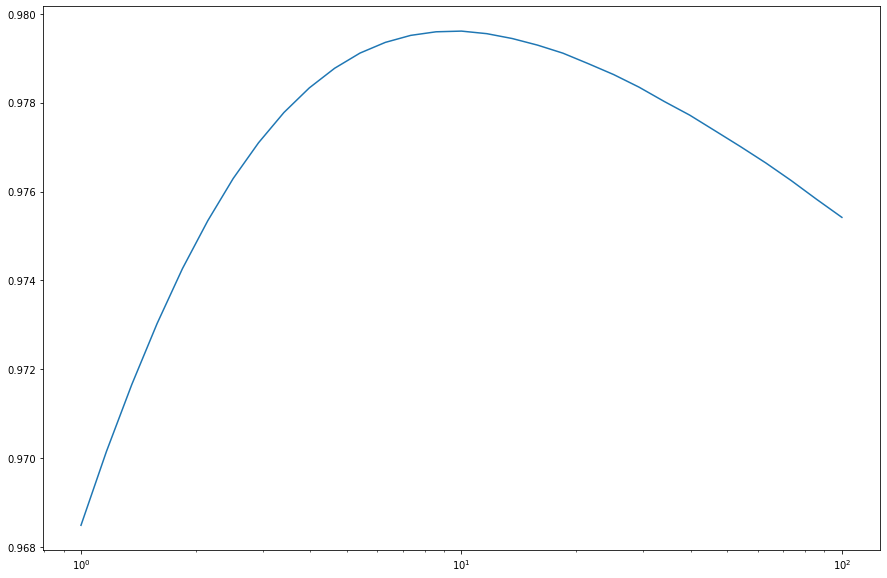

In [34]:
%%time
logit_params = np.logspace(0, 2, 31)

logit = LogisticRegressionCV(Cs=logit_params, cv=skf, multi_class='ovr', scoring='roc_auc', random_state=SEED, n_jobs=-1)
logit.fit(X_train, y)
logit_cv_scores = logit.scores_[1]
logit_mean_cv_scores = np.apply_along_axis(np.mean, 0, logit_cv_scores)
logit_best_C, logit_best_score = max(zip(logit_params, logit_mean_cv_scores), key=lambda x: x[1])
print('C: {}, score: {}'.format(logit_best_C, logit_best_score))

plt.figure(figsize=(15, 10))
plt.plot(logit_params, logit_mean_cv_scores)
plt.xscale('log')

Построим кривую обучения:

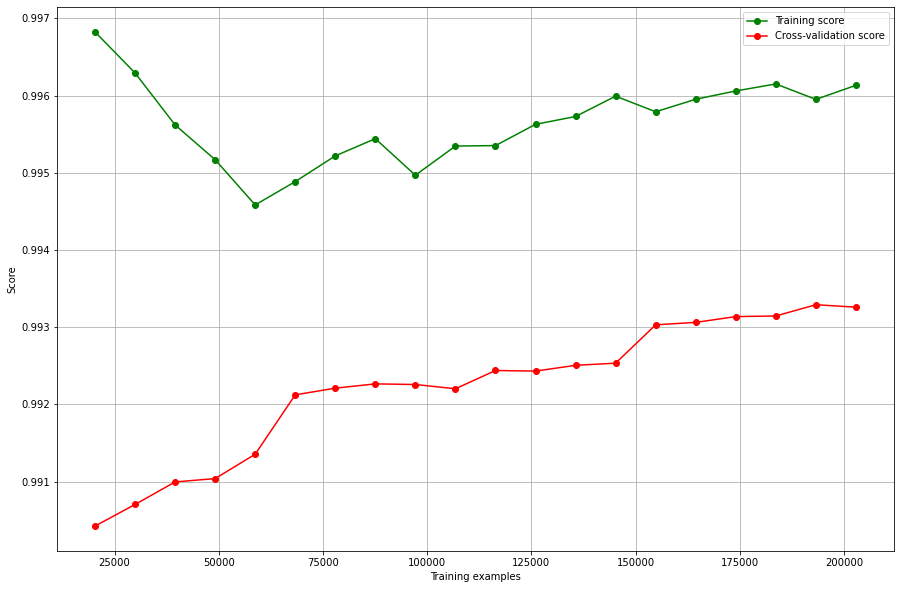

Wall time: 4min 11s


In [35]:
%%time
train_sizes_abs, train_scores, val_scores = learning_curve(LogisticRegression(C=logit_best_C, random_state=SEED, n_jobs=-1), 
                                                            X_train, y, 
                                                            train_sizes=np.linspace(0.1, 1.0, 20), cv=skf)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
plt.figure(figsize=(15, 10))
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

Здесь хорошо видно, что качество на валидации продолжает понемногу улучшаться, но сохраняется все тот же разрыв порядка 0.3%. Качество на обучающей выборке продолжает расти. Все это говорит о недообучении. Оптимальный коэффициент регуляризации мы подобрали, а усложнить модель логистической регрессии можно только добавлением новых признаков. Разумнее попробовать более мощную модель.

### Оценка модели

Выведем значения основных метрик:

In [36]:
logit_pred = logit.predict(X_train)
print(classification_report(y, logit_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251264
           1       0.96      0.60      0.74      2297

    accuracy                           1.00    253561
   macro avg       0.98      0.80      0.87    253561
weighted avg       1.00      1.00      1.00    253561



In [37]:
confusion_matrix(y, logit_pred)

array([[251199,     65],
       [   915,   1382]], dtype=int64)

Модель очень хорошо отсеивает сессии, не принадлежащие Alice, но неверно предсказывает около 40% сессий Alice.

Посмотрим, как выглядят сессии Alice, чтобы понять, почему:

In [38]:
alice_sessions = pd.DataFrame(make_site_names(train_df[site_columns], site_dic, sparse=False), 
                              columns=site_columns)
alice_sessions['prediction'] = logit.predict(X_train)
alice_sessions = alice_sessions[y == 1]

Правильно предсказанные сессии Alice:

In [39]:
alice_sessions[alice_sessions['prediction'] == 1]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,prediction
1295,info-jeunes,facebook,info-jeunes,twitter,info-jeunes,twitter,facebook,info-jeunes,twitter,facebook,1
1297,info-jeunes,twitter,facebook,twitter,info-jeunes,facebook,twitter,google,info-jeunes,twitter,1
1300,facebook,twitter,info-jeunes,twitter,facebook,info-jeunes,twitter,facebook,info-jeunes,twitter,1
1325,facebook,twitter,facebook,info-jeunes,twitter,info-jeunes,info-jeunes,twitter,facebook,info-jeunes,1
1347,twitter,facebook,twitter,facebook,facebook,facebook,anonymousdmp,cashtrafic,facebook,facebook,1
...,...,...,...,...,...,...,...,...,...,...,...
237561,uuidcshmg,facebook,twitter,tynt,twitter,adyoulike,youtube,demotivateur,facebook,demotivateur,1
237566,uuidcshmg,facebook,twitter,tynt,twitter,youtube,demotivateur,facebook,demotivateur,uuidcshmg,1
237569,facebook,twitter,tynt,demotivateur,twitter,youtube,demotivateur,facebook,uuidcshmg,facebook,1
237572,twitter,tynt,twitter,youtube,demotivateur,demotivateur,youtube,facebook,demotivateur,uuidcshmg,1


Неправильно предсказанные сессии Alice:

In [40]:
alice_sessions[alice_sessions['prediction'] == 0]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,prediction
1278,bing,microsoft,google,google,google,google,google,info-jeunes,google,twitter,0
1362,rutube,rutube,rutube,rutube,rutube,rutube,rutube,rutube,cashtrafic,anonymousdmp,0
1364,facebook,facebook,facebook,facebook,facebook,gravatar,gravatar,gravatar,anonymousdmp,facebook,0
1367,vk,facebook,google,google,google,google,google,google,google,google,0
1497,google,google,congres-medical,google,twitter,congres-medical,google,congres-medical,congres-medical,google,0
...,...,...,...,...,...,...,...,...,...,...,...
237518,twitter,google,google,google,google,demotivateur,youtube,jquery,adyoulike,demotivateur,0
237542,facebook,facebook,facebook,youtube,uuidcshmg,demotivateur,facebook,twitter,demotivateur,tynt,0
237576,oxom,sddan,lijit,danstonchat,gwallet,danstonchat,sddan,danstonchat,sddan,danstonchat,0
237586,hotmail,live,live,omtrdc,omtrdc,live,live,live,live,live,0


Можно видеть, что у Alice есть солидная доля сессий, состоящих почти полностью из таких сайтов, как google, youtube, facebook, twitter и т.д. Понятно, что такие сессии сложно отличить от сессий других пользователей.

### Отправка результата на Kaggle

Обучим наилучшую найденную модель на всей обучающей выборке:

In [41]:
%%time
best_model = LogisticRegression(C=logit_best_C, random_state=SEED, n_jobs=-1).fit(X_train, y)

Wall time: 4.37 s


Построим предсказания на тестовой выборке (без целевого признака) и узнаем результат на публичном лидерборде в соревновании на Kaggle:

In [42]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [43]:
logit_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'LogReg_final.csv'))

Результат на публичном лидерборде - 0.94916.

### Безуспешные эксперименты

Следующие попытки не принесли положительного результата (качество не улучшается):
* Использование кросс-валидации для временных рядов - `TimeSeriesSplit`
* Использование признаков, касающихся времени сессии - длительность сессии; доля времени, проведенного на популярных сайтах
* Использование комбинированных признаков из сайтов и времени их посещения
* Использование комбинированных признаков из сайтов и их суммарного времени посещения за сессию

### Выводы

Построенная модель может применяться в сфере информационной безопасности. С помощью модели можно определить, был ли совершен взлом аккаунта веб-сервиса, еще до того, как об этом заявит владелец аккаунта или злоумышленник совершит вредоносное действие. Таким же образом можно отслеживать нелегальную передачу аккаунта, например, продажу.

Существующие методы контроля доступа лишь затрудняют проникновение злоумышленника, но не решают проблему взлома полностью. Узким местом остается использование пароля, который может быть потерян, украден, перехвачен или подобран. Использование модели может помочь там, где эти методы бессильны - в ситуации, когда злоумышленник уже обладает паролем пользователя.